# Hand Gesture Recognition

Abstract

Use of hand gestures is a common way of communication and we do a lot of hand gesture in our daily life. Imagine a presentation being done without the use of any remote or mouse control but using gestures. There are devices which are used to measure these hand gestures. The project is focused on the conversion of the extracted voltage fluctuation output from the device into a meaningful gesture.

Device and Data

The device that is used for generating the data points is home made. We[1] have created a glove which uses flex sensor, accelerometer and gyroscope to measure finger and hand movements. The device uses Arduino2560 programmer for generation of the signals and writing it to any serial port.

Using the above configuration, around 10 training and test data (gestures) is generated. 

Machine Learning Proposal

The data from accelerometer and gyroscope are time series data points. Use of Dynamic Time Warping (DTW) algorithm seems to be more relevant in this case. DTW is used for measuring similarity between two temporal sequences. Let us assume you have made a gesture of the alphabet ‘O’. Now to do that all you have to do a circle with your hand. This dimensions and speed of the gesture might vary from person to person but they are all similar. DTW can measure this similarity in a efficient manner. We will discuss this further along the path.

Finger movement are detected by flex sensors which has a range of value and more or less same for all person. Using all the three data types as one dimension does not make much sense. I am proposing a ensemble learning and gain more info along the progress.

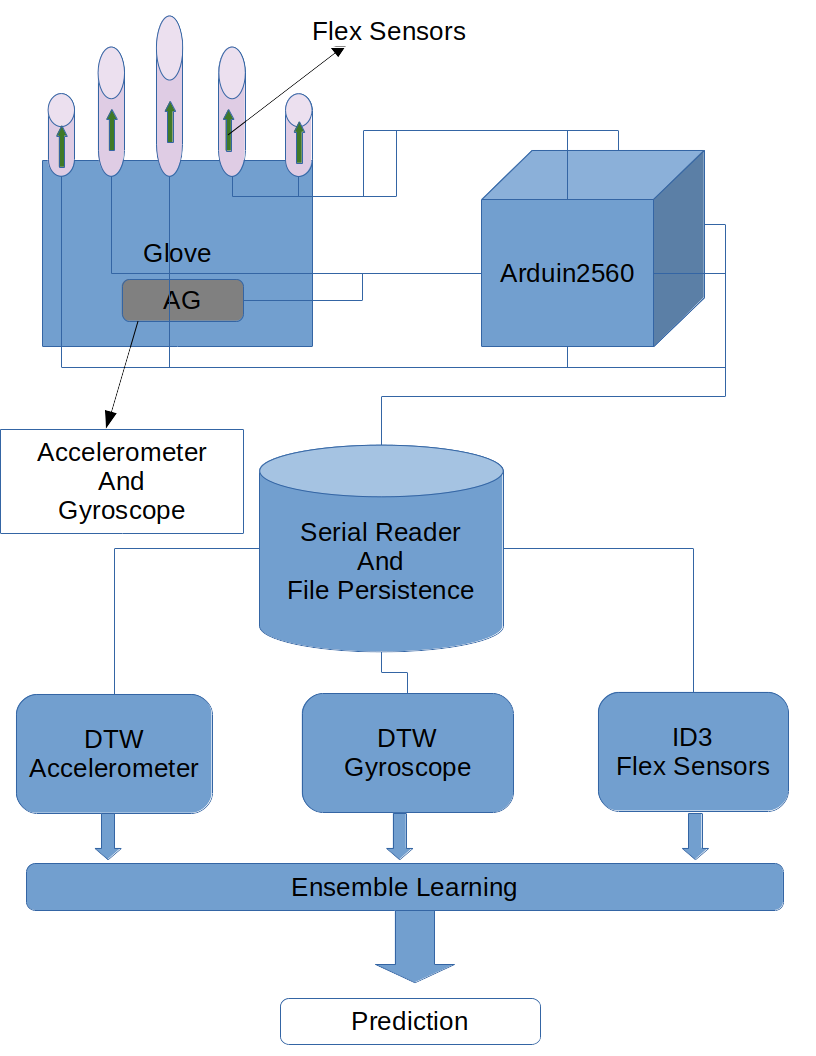

In [1]:
from IPython.display import Image
Image(filename='./Block_Diagram.png', width=500)

Data Metrics

X = [3.61,15.16,-4.81,-0.07,1.07,1.52,99.00,60.00,54.00,99.00,2.00]

First three values are x,y and z from accelerometer.
Next three values are angular velocity of x,y and z co-ordinates from gyroscope.

Last five values are finger position right from thumb to little finger (pinky) from flex sensors (5).

# Phase - I 

<b>Data Generation :</b> 
Since the device dumps data onto serial port , we are going to need a serial port reader which can not only reads it but also saves it for training and test purposes. The following code uses python's threading capabilities to read the serial data. The reason threading is required as we need an interactive session to generate test and train data which can take inputs from command line in foreground while reading from serial port and dumping data on disk in background.

In [2]:
import threading
import serial 


class SerialReader (threading.Thread):

    def __init__(self, threadID, name, counter):
        threading.Thread.__init__(self)
        self.threadID = threadID
        self.name = name
        self.counter = counter
        self.exit = False
        self.ser = serial.Serial('/dev/ttyACM1', 9600)
        self.data = []
    
    def stop(self):
        self.exit = True
        return self.data
        
    def run(self):
        while not self.exit:
            self.data.append(self.ser.readline())
        self.ser.close()
        

Using the above thread base serial reader to create our interactive tool for data generation.

<b>Note : </b>Expects the device to be connected for generating data. 

In [6]:
import os.path as osp
import sys

FOLDER_SPACE = "/home/sabyasachi/Documents/Indiana_University/Spring_2018/Applied_Machine_Learning/Final_Project/test/"


def start():
    while True:
        cmd = input('Enter T for train , type anything else to exit : ')
        processCmd(cmd)


def train():
    word = input('Enter the word for training : ')
    while True:
        cmd = input('Press enter to start or "e" to exit : ')
        if cmd == '':
            rdr = SerialReader(1, "Reader-Thread", 1)
            rdr.start()
            input('Press enter to stop : ')
            data = rdr.stop()
            storeData(word, data)
        elif cmd == 'e':
            break;


def processCmd(cmd):
    if cmd.upper() == 'T':
        train()
    else:
        print('Exiting ...  ')
        sys.exit(0)          


def storeData(word, data):
    filename = "_".join(word.split()) 
    file = open(FOLDER_SPACE + osp.sep + filename + '.txt', 'a+', 1024)
    for dp in data:
        file.write(dp.decode('utf-8', 'ignore'))
    file.write("---------END--------\n")
    file.close()

# Requires main from threading
if __name__ == "__main__":
    start()


Enter T for train , type anything else to exit : e
Exiting ...  


SystemExit: 0

/home/sabyasachi/Programs/anaconda/envs/iuconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Using the above tool , both training and testing data has been generated and store in data and test folder respectively.

# Exploratory Data Analysis

We will now analyze the train data generated for gesture "hi".

Data is stored as comma separated values. Time series data set are separated by "--------END------" marker. We have to take care of this while loading the data into panda data frame. Since each file exhibits one and only one gesture with different time series data, we need our data loader to read all files avaiable in a given folder

<i>Enum Class for differentiating Test and Train Data types</i>

In [34]:
from enum import Enum

class DataType(Enum):
    train = 1
    test = 2

In [42]:
import pandas as pd
import numpy as np

columns = ["cord_x", "cord_y", "cord_z", "tilt_x", 'tilt_y', 'tilt_z', 'thumb', 'index', 'middle', 'ring', 'little']
SPLIT_MARKER = '---------END--------'


def readGesture(gesture, type=DataType.test):
    if type == DataType.test:
        return pd.read_csv('test/' + str(gesture) + '.txt', names=columns)
    elif type == DataType.train:
        return pd.read_csv('data/' + str(gesture) + '.txt', names=columns)
    else:
        raise Exception("Invalid type ")


def splitData(data):
    training_list = [];train_data = pd.DataFrame(columns=columns, dtype=np.float64)
    for row in range(len(data)):
        row_data = data.iloc[row].copy()
        if row_data.cord_x == SPLIT_MARKER:
            train_data.dropna(axis=0, inplace=True)
            training_list.append(train_data)
            train_data = pd.DataFrame(columns=columns, dtype=np.float64)
        else:
            train_data.loc[len(train_data)] = row_data
    return training_list


def getAllDataFileName(type=DataType.train):
    from os import listdir
    from os.path import isfile, join
    if type == DataType.test:
        DATA_PATH = 'test/'
    else:
        DATA_PATH = 'data/'
    onlyfiles = [f for f in listdir(DATA_PATH) if isfile(join(DATA_PATH, f))]
    names = []
    for file in onlyfiles:
        names.append(file.split(".")[0])
    return names


def getData(gesture='wrong', type=DataType.train):
    raw_gesture_data = readGesture(gesture, type=DataType.train)
    return splitData(raw_gesture_data)


def getTrainData():
    train_file = getAllDataFileName(DataType.train)
    X_train = [];y_train = []
    for gesture in train_file:
        for data in getData(gesture):
            X_train.append(data)
            y_train.append(gesture)
    return X_train, y_train


def getTestData():
    test_file = getAllDataFileName(DataType.test)
    X_test = [];y_test = []
    for gesture in test_file:
        for data in getData(gesture):
            X_test.append(data)
            y_test.append(gesture)
    return X_test, y_test



Find all training files avaialble :

In [43]:
from os import listdir
from os.path import isfile, join
TRAIN_DATA_PATH = 'data/'
onlyfiles = [f for f in listdir(TRAIN_DATA_PATH) if isfile(join(TRAIN_DATA_PATH, f))]
onlyfiles

['alright.txt',
 'bye.txt',
 'correct.txt',
 'crazy.txt',
 'go.txt',
 'hi.txt',
 'I.txt',
 'me.txt',
 'not_sure.txt',
 'stop.txt',
 'what.txt',
 'wrong.txt',
 'you.txt']

Using the above features we can load all the training files into pandas data frame. Let's do some analysis on wrong.txt

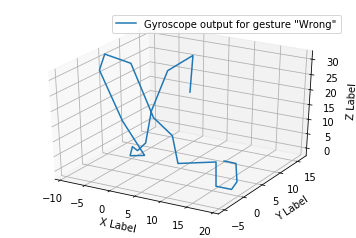

In [44]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

data_list = getData(gesture='wrong')
data = data_list[1]
X = np.array(data.cord_x.astype('float64').values).astype(int)
Y = np.array(data.cord_y.astype('float64').values).astype(int)
Z = np.array(data.cord_z.astype('float64').values).astype(int)

# Plotting graph


fig = plt.figure()
ax = fig.gca(projection='3d')


ax.plot(X, Y, Z, label='Gyroscope output for gesture "Wrong"')
ax.legend()
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()


The above 3D plot shows a cross on the space with lot of noise. But this looks good and now let's move on to other attributes. Accelerometer data gives the change in angular velocity or acceleration. Let's try to plot a time series for the accelerometer data set.

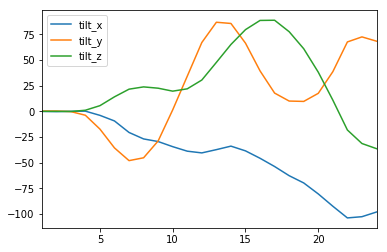

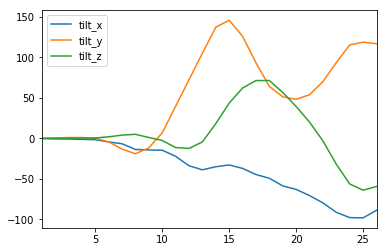

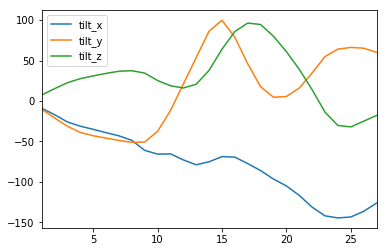

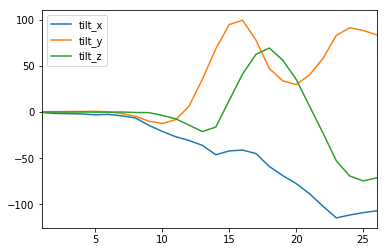

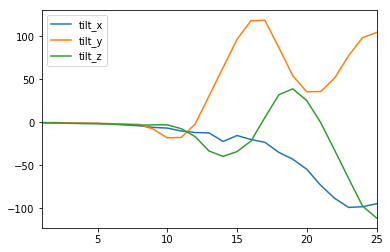

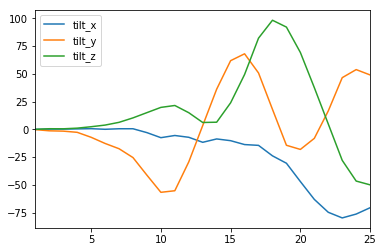

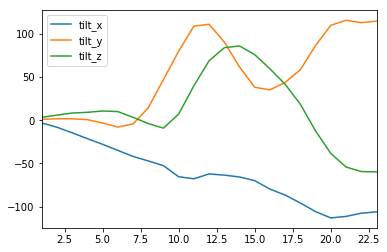

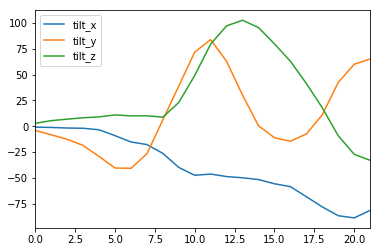

In [45]:
for data in data_list:
    acc_ts = data[["tilt_x","tilt_y","tilt_z"]].cumsum()
    acc_ts.plot()
plt.show()

The above time series plot for accelerometer data shows similarities between different data set of gesture wrong. Dynamic Time Warping seems to be good candidate for both gyroscope and accelerometer data

<b>Flex Sensors</b>

The last five columns are from flex sensors. These data are change in voltage caused by change in resistance during finger movement. We should choose an example such that includes finger movement during gesture. Let's choose 'stop' and analys the data.

In [54]:
data_list = getData(gesture='hi')
data_list[2][['thumb', 'idx_point', 'middle', 'ring', 'little']].head()

,thumb,idx_point,middle,ring,little
1,23.0,29.0,14.0,29.0,3.0
2,22.0,25.0,15.0,29.0,3.0
3,23.0,29.0,14.0,29.0,3.0
4,23.0,23.0,15.0,28.0,3.0
5,23.0,24.0,16.0,28.0,3.0


In [53]:
for data in data_list:
    fing_data = data[['thumb', 'idx_point', 'middle', 'ring', 'little']]
    print(fing_data.describe())

           thumb  idx_point     middle       ring  little
count  32.000000  32.000000  32.000000  32.000000    32.0
mean   32.031250  32.687500  19.968750  37.343750     3.0
std    18.072407  13.852768   9.358399  16.296862     0.0
min    16.000000  19.000000  11.000000  21.000000     3.0
25%    20.000000  21.000000  12.750000  24.000000     3.0
50%    21.500000  29.500000  17.500000  32.000000     3.0
75%    47.000000  39.750000  25.500000  47.500000     3.0
max    74.000000  66.000000  40.000000  74.000000     3.0
            thumb  idx_point     middle       ring  little
count   26.000000  26.000000  26.000000  26.000000    26.0
mean    43.115385  37.423077  23.730769  43.384615     3.0
std     27.048589  14.497374   9.128232  16.996651     0.0
min     18.000000  21.000000  14.000000  25.000000     3.0
25%     21.000000  24.750000  16.250000  28.750000     3.0
50%     28.500000  32.000000  20.000000  35.500000     3.0
75%     64.500000  52.250000  31.500000  59.500000     3.0
max   

We might able to use the mean but let's try with time series plot again in case there is any similarities.

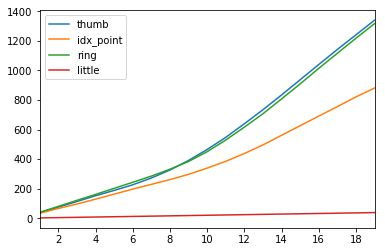

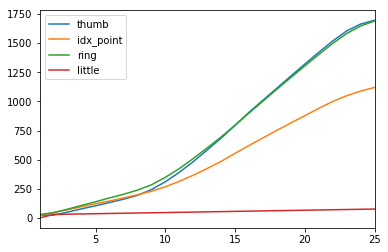

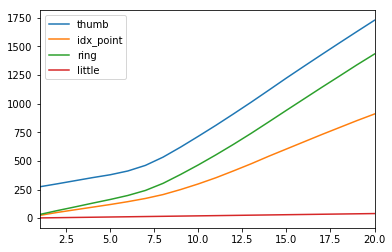

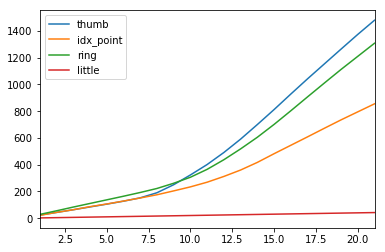

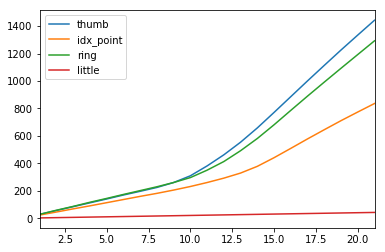

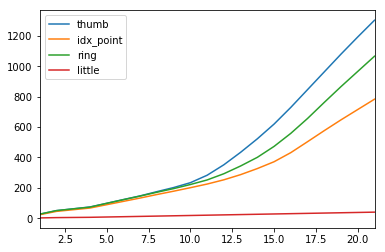

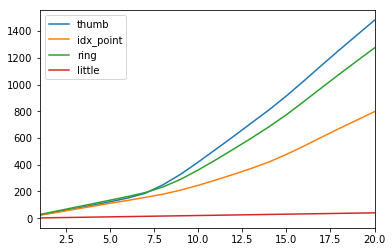

In [57]:
data_list = getData(gesture='alright')
for data in data_list:
    fing_ts = data[['thumb', 'idx_point', 'middle', 'ring', 'little']].cumsum()
    fing_ts.plot()
plt.show()

Well, flex sensors have also simlarities in time series plot. At this point DTW seems apt for all three sensor data. But there is one <u>disadvantage</u>.
<li>
DTW is classification algorithm and will have performance effects when the data set grows large
</li>

Since we have three different attributes gyroscope, acclerometer and flex sensors, it seems reasonable to use DTW separately on them. We requires some normalization and column extractor for seamlesss usage of both train and det data.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
from sklearn.preprocessing.data import StandardScaler


def removeNonNumeric(df):
    return pd.DataFrame(df[df.apply(lambda row : isNumeric(row), axis=1)], dtype=np.float64)

    
def isNumeric(row):
    try:
        row.astype('float')
    except Exception as e:
        print('--------------------NON-NUMERIC-DATA-ERROR--------------------')
        print(row)
        print(e)
        print('-----------------------ERROR-ENDS-HERE------------------------')
        return False
    return True


#--------------------------------End Of Utility Common Functions---------------------------
class DataFrameSelector(BaseEstimator, TransformerMixin):

    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """
        Expects a list of panda data frames
        """
        tr = []
        for x in X:
            x = removeNonNumeric(x)
            tr.append(x[self.attribute_names])
        return tr

# -----------------------------End Of DataFrame Selector -------------------------


class CoordinateNormalizer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        tr = []
        for x in X:
#             x = removeNonNumeric(x)
            first_row = x.iloc[0]
            tr.append(x.apply(lambda row: self.norm(row, first_row), axis=1))
        return tr
        
    def norm(self, row, first_row):
        try:
            return row.astype('float') - first_row.astype('float')
        except Exception as e:
            print(row)
            print(e)
            return False
            
# ----------------------- End Of Coordinate Normalizer -------------------


class AccelerometerNormalizer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        tr = []
        for x in X:
#             x = removeNonNumeric(x)
            tr.append(x.apply(lambda row: self.norm(row), axis=1))
        return tr
        
    def norm(self, row):
        return np.sign(row.astype('float'))          

# --------------------------End Of Accelerometer Normalizer---------------------


class AnalogVoltageScaler(BaseEstimator, TransformerMixin):      
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        tr = []
        for x in X:
#             x = removeNonNumeric(x)
            tr.append(self.minMaxNorm(x))
        return tr
    
    def minMaxNorm(self, df):
        result = df.copy()
        for feature_name in df.columns:
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
        return result
    


I have come up with three different transformers : 

<li>CoordinateNormalizer : This basically shifts the co-ordinates to its zero setting. This gives better result during warping</li>
<li>AccelerometerNormalizer : Accelerometer gives the data in milli g where g -> gravity acceleration i.e. 9.8 m/s^2. These data does not add much to the prediction as acceleration might vary for different person. Instead of using the voltage figure , we would be using the direction vector only. This normalizer takes only the sign and dumps the numeric value.</li>
<li>AnalogVoltageScaler : Flex sensor data are result of change in the resistence caused dure to finger movement. This data is helpful and so we just use min max normalization to scale the values from 0 to 1.</li>

Apart from that we have a column extractor which not only separates columns but also remove non numeric rows that may cause error in future calculations

Following pipelines will be used for transformation and prediction

In [ ]:
from sklearn.pipeline import Pipeline

gyro_attr_names = ["cord_x", "cord_y", "cord_z"]
acc_attr_names = ["tilt_x", 'tilt_y', 'tilt_z']
fgr_attr_names = ['thumb', 'index', 'middle', 'ring', 'little']
gyro_pipeline = Pipeline([       
        ('selector', DataFrameSelector(gyro_attr_names)),
        ('cord_norm', CoordinateNormalizer()),        
    ])

acc_pipeline = Pipeline([       
        ('selector', DataFrameSelector(acc_attr_names)),
        ('acc_norm', AccelerometerNormalizer()),        
    ])

flex_pipeline = Pipeline([       
        ('selector', DataFrameSelector(fgr_attr_names)),
        ('std_scaler', AnalogVoltageScaler()),        
    ])